## Setup

#### Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn import tree
import combined_data

%matplotlib inline

dev_dataset_rows = 150000

## Data Prepartaion

### Loading movie titles

In [2]:
columns = [0,1,2]
movies = pd.read_csv(
    "netflix-data/movie_titles.csv",
    encoding="ISO-8859-1",
    usecols=columns
)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17770 entries, 0 to 17769
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      17770 non-null  int64  
 1   Year    17763 non-null  float64
 2   Title   17770 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 416.6+ KB


Only 7 titles have missing data so they are dropped and years converted to int values

In [3]:
movies.dropna(inplace=True)
movies.Year = movies.Year.astype(int)
movies

,ID,Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


### Examining the ratings dataset

Converting `combined_data_n.txt` files into feather format if necessary and loading them for analysis. (Functions defined in `combined_data.py`) 

In [4]:
combined_data.initialize_all_data()
ratings = pd.read_feather(combined_data.combined_ratings_path())
ratings = ratings.head(dev_dataset_rows)
ratings.head()

,movie,user,rating
0,1,1488844,3
1,1,822109,5
2,1,885013,4
3,1,30878,4
4,1,823519,3


In [5]:
ratings.dtypes

movie     int64
user      int64
rating    int64
dtype: object

In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   movie   150000 non-null  int64
 1   user    150000 non-null  int64
 2   rating  150000 non-null  int64
dtypes: int64(3)
memory usage: 3.4 MB


The dataset has no missing values

In [7]:
ratings.isna().sum()

movie     0
user      0
rating    0
dtype: int64

Dataframe shape

In [8]:
ratings.shape

(150000, 3)

No duplicate ratings in the dataset

In [9]:
ratings.duplicated().any()

False

### Adding movie years to the ratings

In [10]:
"""years = movies.copy().drop("Title", axis=1)
ratings = pd.merge(ratings, years, left_on="movie", right_on="ID")
ratings.drop("ID", axis=1, inplace=True)
ratings"""

'years = movies.copy().drop("Title", axis=1)\nratings = pd.merge(ratings, years, left_on="movie", right_on="ID")\nratings.drop("ID", axis=1, inplace=True)\nratings'

In [11]:
#ratings.Year.value_counts()

## Exploratory Data Analysis

### Ratings bar plot

In [12]:
ratings_count = ratings.rating.value_counts()
ratings_count

rating
4    54383
3    41730
5    32693
2    14200
1     6994
Name: count, dtype: int64

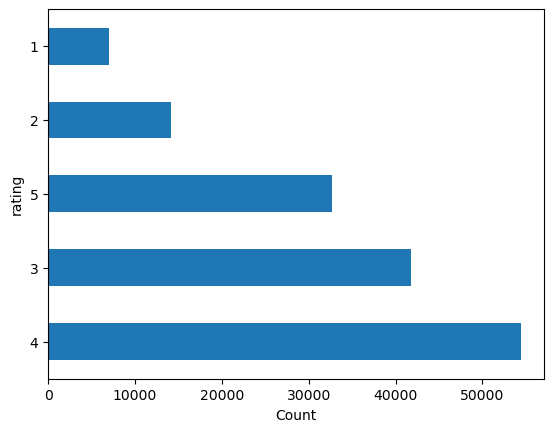

In [13]:
ratings_count.plot(kind="barh", xlabel="Count");

#### Observation

The vast majority of films are rated favorably or neutral<hr>

### Ratings box plot

In [14]:
ratings.rating.median()

4.0

In [15]:
q1 = np.percentile(ratings.rating, 25)
q3 = np.percentile(ratings.rating, 75)
iqr = q3 - q1
print(f"Q1: {q1}\nQ3:{q3}\nInterquartile Range:{iqr}")

Q1: 3.0
Q3:4.0
Interquartile Range:1.0


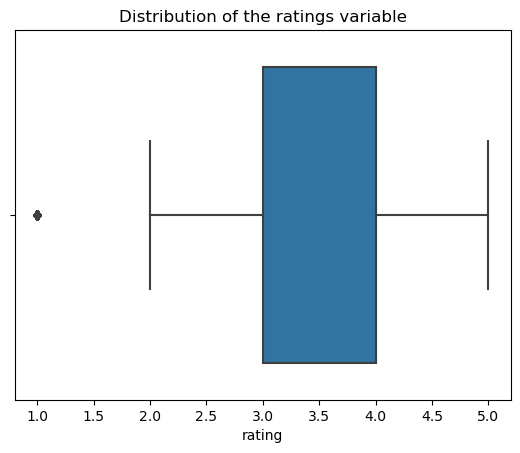

In [16]:
sns.boxplot(x='rating', data=ratings)
plt.title("Distribution of the ratings variable");

#### Observations
- The ratings have a median of 4 and an IQR of 1
- There appears to be outliers at the lower end of the ratings which might indicate class imbalance
<hr>

### Reducing rating categories (Negative: 0, Positive: 1)

In [17]:
ratings["category"] = ratings.rating.apply(
    lambda x:
        0 if x <= 3
        else(1 )
)
ratings.head()

,movie,user,rating,category
0,1,1488844,3,0
1,1,822109,5,1
2,1,885013,4,1
3,1,30878,4,1
4,1,823519,3,0


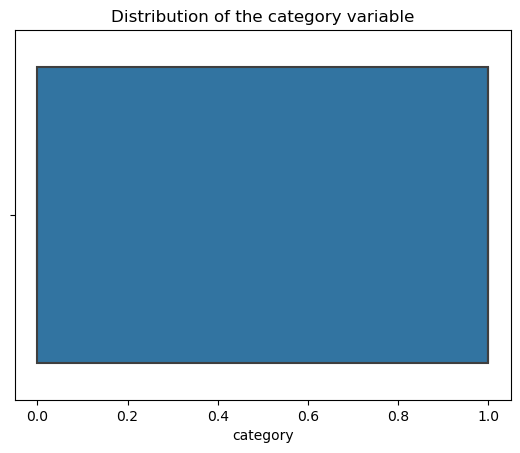

In [18]:
sns.boxplot(x='category', data=ratings)
plt.title("Distribution of the category variable");

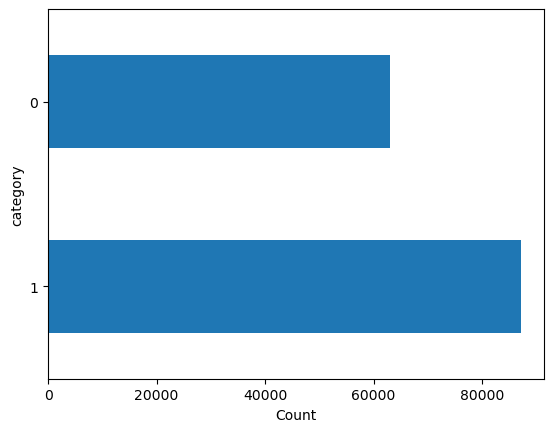

In [19]:
ratings_count = ratings.category.value_counts()
ratings_count.plot(kind="barh", xlabel="Count");

#### Observations
Reducing the categories reduces the strength of the outliers
<hr>

With our rating categories set, we can drop the original rating column

In [20]:
ratings.drop("rating", axis=1, inplace=True)
ratings

,movie,user,category
0,1,1488844,0
1,1,822109,1
2,1,885013,1
3,1,30878,1
4,1,823519,0
...,...,...,...
149995,30,663627,1
149996,30,450324,0
149997,30,2638972,0
149998,30,1696063,1


### Heatmap

In [21]:
ratings_corr =  ratings.corr()
ratings_corr

,movie,user,category
movie,1.000000,-0.001480,0.144642
user,-0.001480,1.000000,0.003369
category,0.144642,0.003369,1.000000


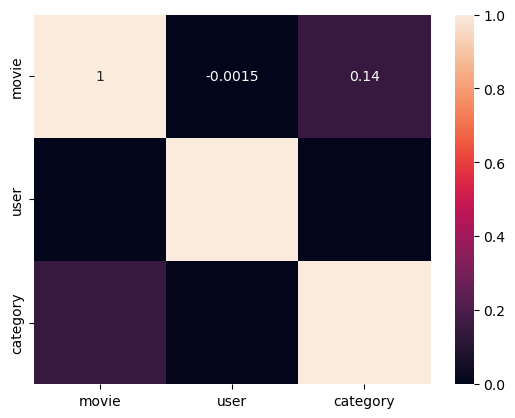

In [22]:
sns.heatmap(ratings_corr, annot=True);

#### Observations
There appears to be no strong correlation between any of the variables. This indicates a non-linear more omplex relationship

## Modeling

In [23]:
y = ratings.category
X = ratings.drop("category", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [24]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_preds) * 100, 2)}%")

Accuracy: 54.92%


In [25]:
"""fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(clf,
               feature_names = ratings.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()"""

"fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)\ntree.plot_tree(clf,\n               feature_names = ratings.columns, \n               class_names=np.unique(y).astype('str'),\n               filled = True)\nplt.show()"

<hr>

### Hyperparameter Tuning

In [26]:
param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": [5, 6, 7],
    "min_samples_split": [2, 9, 10, 11],
    "min_samples_leaf": [5, 6, 7],
    'max_features': [None],
}
clf_grid = DecisionTreeClassifier()
grid = GridSearchCV(estimator=clf_grid, param_grid=param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
best_params = grid.best_params_
print("Best Parameters:", best_params)


# Get the best estimator
best_estimator = grid.best_estimator_
y_preds_grid = best_estimator.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_preds_grid) :.2%}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 6, 'min_samples_split': 2}
Accuracy: 64.81%


In [27]:
tuned_tree = DecisionTreeClassifier(criterion="entropy", max_depth=7, max_features=None, min_samples_leaf=5, min_samples_split=2)
tuned_tree.fit(X_train, y_train)
y_preds = tuned_tree.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_preds) :.2%}")

Accuracy: 64.81%


#### Observations
With optimal parameters the model's accuracy increases by roughly 10%<hr>

In [32]:
bagged_tree =  BaggingClassifier(tuned_tree, n_estimators=20)
bagged_tree.fit(X_train, y_train)
train_score = bagged_tree.score(X_train, y_train)
test_score = bagged_tree.score(X_test, y_test)
print(f"Training score:{train_score :.2%}\nTest score: {test_score :.2%}")

Training score:65.21%
Test score: 64.83%


In [29]:
forest = RandomForestClassifier(n_estimators=10, max_depth= 5)
forest.fit(X_train, y_train)
train_score = forest.score(X_train, y_train)
test_score = forest.score(X_test, y_test)
print(f"Training score:{train_score :.2%}\nTest score: {test_score :.2%}")
mean_rf_cv_score = np.mean(cross_val_score(forest, X_train, y_train, cv=3))
print(
    f"Mean Cross Validation Score for Random Forest Classifier: {mean_rf_cv_score :.2%}"
)

Training score:63.90%
Test score: 63.51%
Mean Cross Validation Score for Random Forest Classifier: 63.83%


<hr>

In [77]:
pivot_df = ratings.pivot_table(index='user', columns='movie', values='category')
pivot_df.fillna(0, inplace=True)
pivot_df.reset_index(inplace=True)
pivot_df

movie,user,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116107,2649375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
116108,2649378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116109,2649388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116110,2649426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [56]:
ratings.movie.value_counts().tail(10)


movie
21    218
22    203
11    198
2     145
4     142
13    125
14    118
20    116
9      95
7      93
Name: count, dtype: int64

In [78]:
from sklearn.cluster import KMeans

ratings_cluster = pivot_df.copy()
X_cluster = ratings_cluster.drop(['user'], axis=1) 
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_cluster)

# Adding cluster labels to the DataFrame
ratings_cluster['cluster'] = cluster_labels
ratings_cluster

/home/ian/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


movie,user,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,cluster
0,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
1,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116107,2649375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
116108,2649378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
116109,2649388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
116110,2649426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1


In [79]:
ratings_cluster.cluster.value_counts()

cluster
0    47592
1    37127
4    21335
2     5453
3     4605
Name: count, dtype: int64

In [81]:
from sklearn.neighbors import KNeighborsClassifier


X_train, X_test, y_train, y_test = train_test_split(X_cluster, ratings_cluster['cluster'], test_size=0.2, random_state=42)
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)
y_pred = knn_classifier.predict(X_test)

# Evaluating the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


In [132]:
def get_recs(cluster):
    cluster_data = ratings_cluster[ratings_cluster['cluster'] == cluster]
    average_ratings = cluster_data.drop(["user", "cluster"], axis=1).mean(axis=0)  # Calculate average ratings for each movie in the cluster
    recommended_movies = average_ratings.sort_values(ascending=False).head(10)  # Get top recommended movies
    #print(f"Cluster {cluster} recommended movies:")
    #print(recommended_movies)
    return recommended_movies

In [76]:
test = ratings_cluster[ratings_cluster.cluster == 1]
av = test.drop(["user", "cluster"], axis=1).mean(axis=0).sort_values(ascending=False)
av.head()

movie
30    1.000000
8    -0.932846
28   -0.940845
17   -0.965380
26   -0.967719
dtype: float64

In [141]:
get_recs(0).index[0]

17

In [106]:
def get_user():
    row = ratings.sample(n=1)
    user = row.head(1).user.values[0]
    return user

In [114]:
def get_cluster(user):
    cluster = ratings_cluster[ratings_cluster.user == user]
    return cluster.head(1).cluster.values[0]

In [125]:
def get_user_reccs(user):
    cluster = get_cluster(user)
    return get_recs(cluster)

In [212]:
def get_movie_name(id):
    return movies[movies["ID"] == id].Title.iloc[0]

In [213]:
get_movie_name(28)

'Lilo and Stitch'

In [230]:
user = get_user()
print(f"User: {user}")
movie_rec = get_user_reccs(user).index
movie = None

for entry in movie_rec:
    if len(ratings[(ratings.user == user) & (ratings.movie == entry)]) > 0:
        continue #has watched the movie before, skip
    else:
        movie = entry
        break
movie_name = get_movie_name(movie)
print(f"Recommendation: {movie}: {movie_name}")
movie_rec

User: 1263102
Recommendation: 18: Immortal Beloved


Index([8, 18, 30, 3, 28, 25, 6, 16, 17, 26], dtype='object', name='movie')

In [231]:
ratings[(ratings.user == user)]

,movie,user,category
10902,8,1263102,1
138899,30,1263102,0


In [232]:
test_row = {
    "movie": movie,
    "user": user
}
input_row = pd.DataFrame(test_row, index=[0])
will_like = bagged_tree.predict(input_row)[0]

if will_like == 1:
    print(f"Models predict user:{user} will like {movie_name}")
else:
    print(f"Models predict user:{user} will NOT like {movie_name}")


Models predict user:1263102 will like Immortal Beloved


<hr>

todo

add year to dataset
try forest
other models
drop ratings = 1 accuracy